In [3]:
# library imports
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_recall_curve
import optuna

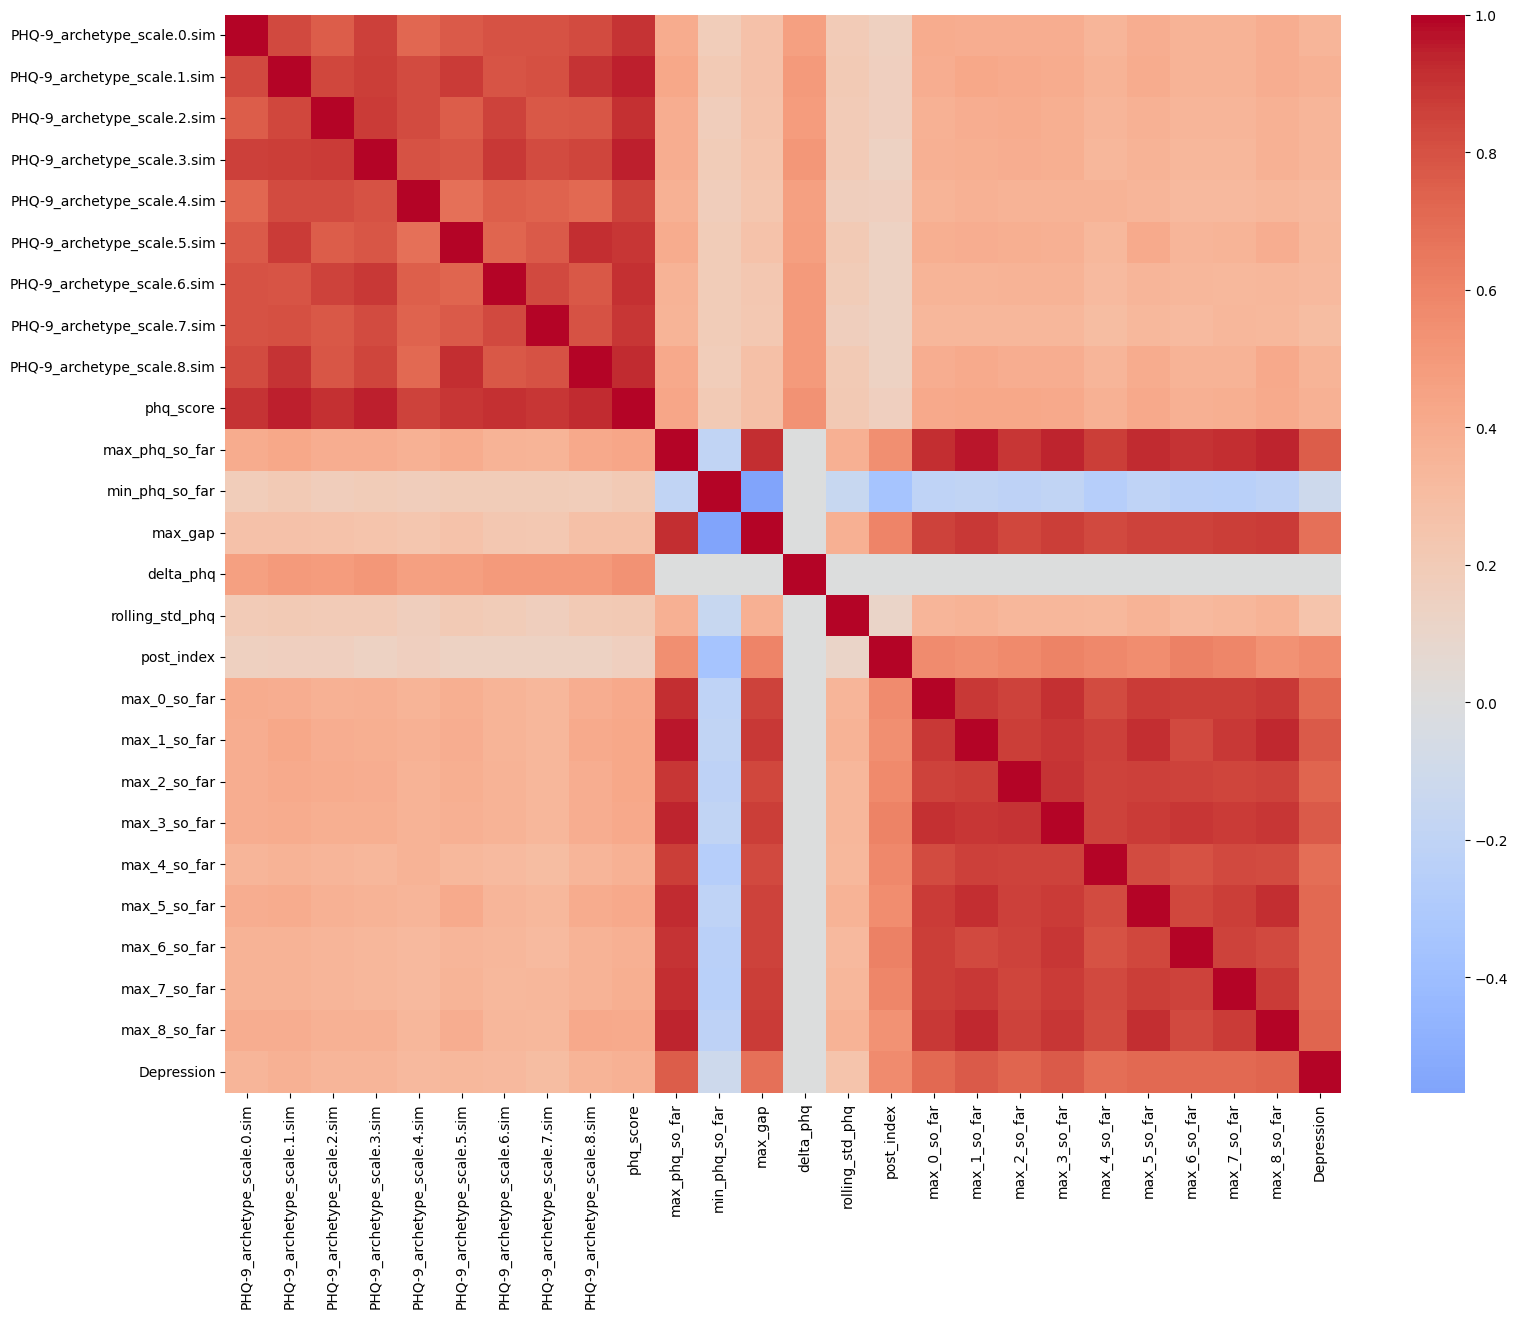

In [4]:
# Load data
phq9_train=pd.read_pickle('../Features/PHQ9_features_train.pickle')
phq9_train=phq9_train.dropna(subset=['body']).copy()

phq9_test=pd.read_pickle('../Features/PHQ9_features_test.pickle')
phq9_test=phq9_test.dropna(subset=['body']).copy()

phq9_cols = ['PHQ-9_archetype_scale.0.sim', 'PHQ-9_archetype_scale.1.sim', 'PHQ-9_archetype_scale.2.sim', 
            'PHQ-9_archetype_scale.3.sim', 'PHQ-9_archetype_scale.4.sim', 'PHQ-9_archetype_scale.5.sim', 
            'PHQ-9_archetype_scale.6.sim', 'PHQ-9_archetype_scale.7.sim', 'PHQ-9_archetype_scale.8.sim', 
            'phq_score', 'max_phq_so_far', 'min_phq_so_far', 'max_gap', 'delta_phq', 'rolling_std_phq', 
            'post_index', 'max_0_so_far', 'max_1_so_far', 'max_2_so_far', 'max_3_so_far', 'max_4_so_far', 
            'max_5_so_far', 'max_6_so_far', 'max_7_so_far', 'max_8_so_far']

# correlation heatmap
corr = phq9_train[phq9_cols + ["Depression"]].corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

In [5]:
# Baseline for phq9 only (post level) - Logistic Regression

# features and labels
phq9_X_train= phq9_train[phq9_cols].values
phq9_y_train=phq9_train['Depression'].values
phq9_X_test  = phq9_test[phq9_cols].values
phq9_y_test  = phq9_test["Depression"].values

print("using features:",phq9_cols)

# Model pipeline
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.1,        
        max_iter=500,
        n_jobs=-1
    ))
])

# predict
clf.fit(phq9_X_train, phq9_y_train)

phq9_y_pred = clf.predict(phq9_X_test)
phq9_y_prob = clf.predict_proba(phq9_X_test)[:, 1]

print(" Classification Report")
print(classification_report(phq9_y_test, phq9_y_pred, digits=4))

auc = roc_auc_score(phq9_y_test, phq9_y_prob)
acc  = accuracy_score(phq9_y_test, phq9_y_pred)
pre  = precision_score(phq9_y_test, phq9_y_pred, pos_label=1)
rec  = recall_score(phq9_y_test, phq9_y_pred, pos_label=1)
f1 = f1_score(phq9_y_test, phq9_y_pred, average="binary")   


print(f"Accuracy     = {acc:.4f}")
print(f"Precision    = {pre:.4f} ")
print(f"Recall       = {rec:.4f} ")
print(f"F1.          = {f1:.4f} ")


## check useful features
coef = clf.named_steps["logreg"].coef_[0]
non_zero_mask = np.abs(coef) > 1e-6
used_features = [c for c, m in zip(phq9_cols, non_zero_mask) if m]

print(f"\n=== phq9 feature selection ===")
print(f"original: {len(phq9_cols)}")
print(f"useful features: {len(used_features)}")
print("useful features:", used_features)

# Find the best threshold for F1 score

# predicted prob scores
probs = phq9_y_prob
# true labels
labels = phq9_y_test
# find best threshold
precision, recall, thresholds = precision_recall_curve(labels, probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Best Threshold Search for F1")
print(f"Best Threshold = {best_threshold:.4f}")
print(f"Best F1 Score  = {best_f1:.4f}")

best_pred = (probs > best_threshold).astype(int)

print("\n=== Evaluation with Optimal Threshold ===")


print(f"Accuracy = {accuracy_score(labels, best_pred):.4f}")
print(f"Precision= {precision_score(labels, best_pred):.4f}")
print(f"Recall   = {recall_score(labels, best_pred):.4f}")
print(f"F1       = {f1_score(labels, best_pred):.4f}")
print(f"ROC-AUC  = {roc_auc_score(labels, probs):.4f}")

using features: ['PHQ-9_archetype_scale.0.sim', 'PHQ-9_archetype_scale.1.sim', 'PHQ-9_archetype_scale.2.sim', 'PHQ-9_archetype_scale.3.sim', 'PHQ-9_archetype_scale.4.sim', 'PHQ-9_archetype_scale.5.sim', 'PHQ-9_archetype_scale.6.sim', 'PHQ-9_archetype_scale.7.sim', 'PHQ-9_archetype_scale.8.sim', 'phq_score', 'max_phq_so_far', 'min_phq_so_far', 'max_gap', 'delta_phq', 'rolling_std_phq', 'post_index', 'max_0_so_far', 'max_1_so_far', 'max_2_so_far', 'max_3_so_far', 'max_4_so_far', 'max_5_so_far', 'max_6_so_far', 'max_7_so_far', 'max_8_so_far']
 Classification Report
              precision    recall  f1-score   support

         0.0     0.9250    0.8736    0.8986     23771
         1.0     0.8112    0.8846    0.8463     14590

    accuracy                         0.8778     38361
   macro avg     0.8681    0.8791    0.8725     38361
weighted avg     0.8817    0.8778    0.8787     38361

Accuracy     = 0.8778
Precision    = 0.8112 
Recall       = 0.8846 
F1.          = 0.8463 

=== phq9 fea

In [6]:
# User-level prediction with logistic regression baseline
#append predictions to test dataframe
results = phq9_test.copy()
results["prob"] = phq9_y_prob
# prediction with best threshold
results["pred"] = (phq9_y_prob > best_threshold).astype(int)

# User-level evaluation function
def evaluate_user_level(results, method="mean", k=3, threshold=0.5):
    # Sort by user and time
    results = results.sort_values(["user_id","created_utc"])
    user_probs  = results.groupby("user_id")["prob"].apply(list)
    user_posts  = results.groupby("user_id")["comment_id"].apply(list)
    
    # true labels
    labels_true = results.groupby("user_id")["Depression"].max()

    user_pred = {}
    decision_post_id = {}
    delay = {}

    for uid in user_probs.index:
        probs, posts = user_probs[uid], user_posts[uid]

        detect_idx = None  

        # === Mean ===
        if method=="mean":
            avg_p = np.mean(probs)
            user_pred[uid] = int(avg_p > threshold)
            detect_idx = next((i for i,p in enumerate(probs) if p>threshold), None)

        # === Max ===
        elif method=="max":
            idx = np.argmax(probs)
            user_pred[uid] = int(probs[idx]>threshold)
            detect_idx = idx if user_pred[uid]==1 else None

        # === Top-K Earliest ===
        elif method=="topk":
            topk_idx = np.argsort(probs)[-k:]
            user_pred[uid] = int(np.mean([probs[i] for i in topk_idx]) > threshold)
            detect_idx = min(topk_idx) if user_pred[uid]==1 else None

        # === Consecutive-K ===
        elif method=="consecutive":
            cnt=0
            for i,p in enumerate(probs):
                cnt = cnt+1 if p>threshold else 0
                if cnt>=k: detect_idx=i; break
            user_pred[uid] = int(detect_idx is not None)

        # Store detection info
        if detect_idx is not None:
            decision_post_id[uid] = posts[detect_idx]
            delay[uid] = detect_idx   
        else:               
            decision_post_id[uid] = None
            delay[uid] = None

    # ===== Metrics =====
    y_pred = np.array([user_pred[u] for u in user_probs.index])
    metrics = dict(
        Accuracy=accuracy_score(labels_true, y_pred),
        Precision=precision_score(labels_true,y_pred),
        Recall=recall_score(labels_true,y_pred),
        F1=f1_score(labels_true,y_pred),
    )

    
    summary = pd.DataFrame({
        "user_id": user_probs.index,
        "true_label": labels_true,
        "pred_label": y_pred,
        "decision_post": [decision_post_id[u] for u in user_probs.index],
        "delay_post_count": [delay[u] for u in user_probs.index]
    })

    return metrics, summary



In [7]:
def find_best_threshold(results, method="mean", k=3, T=200):
    # true labels
    labels_true = results.groupby("user_id")["Depression"].max().values

    thresholds = np.linspace(0.05,0.95,T)  
    best = {"threshold":None, "f1":0}

    for th in thresholds:
        metrics, summary = evaluate_user_level(results, method=method, k=k, threshold=th)
        f1 = metrics["F1"]

        if f1 > best["f1"]:
            best = {"threshold":th, "f1":f1, "summary":summary, "metrics":metrics}

    return best

for m in ["mean","max","topk","consecutive"]:
    best = find_best_threshold(results, method=m, k=3)   
    print(f"\n===== {m.upper()} BEST USER-LEVEL THRESHOLD =====")
    print(f"Optimal τ = {best['threshold']:.4f}")
    print(best["metrics"])   # F1 / Recall / Precision / Accuracy


===== MEAN BEST USER-LEVEL THRESHOLD =====
Optimal τ = 0.5475
{'Accuracy': 0.9719101123595506, 'Precision': 0.8333333333333334, 'Recall': 0.9523809523809523, 'F1': 0.8888888888888888}

===== MAX BEST USER-LEVEL THRESHOLD =====
Optimal τ = 0.9500
{'Accuracy': 0.949438202247191, 'Precision': 0.75, 'Recall': 0.8571428571428571, 'F1': 0.8}

===== TOPK BEST USER-LEVEL THRESHOLD =====
Optimal τ = 0.9455
{'Accuracy': 0.9719101123595506, 'Precision': 0.9, 'Recall': 0.8571428571428571, 'F1': 0.8780487804878049}

===== CONSECUTIVE BEST USER-LEVEL THRESHOLD =====
Optimal τ = 0.9138
{'Accuracy': 0.9662921348314607, 'Precision': 0.8947368421052632, 'Recall': 0.8095238095238095, 'F1': 0.85}


In [8]:
for m in ["mean","max","topk","consecutive"]:
    metrics, summary = evaluate_user_level(results, method=m, k=3, threshold=0.5701)
    print(f"\n=== {m} ===", metrics)
    print(summary.head())



=== mean === {'Accuracy': 0.9719101123595506, 'Precision': 0.8333333333333334, 'Recall': 0.9523809523809523, 'F1': 0.8888888888888888}
                         user_id  true_label  pred_label decision_post  \
user_id                                                                  
subject_08eA70p  subject_08eA70p         0.0           1       ME5aB0g   
subject_0ROAtkI  subject_0ROAtkI         0.0           0          None   
subject_0bCCxpq  subject_0bCCxpq         0.0           0          None   
subject_0sOkMfd  subject_0sOkMfd         0.0           0          None   
subject_16b6b7C  subject_16b6b7C         0.0           0          None   

                 delay_post_count  
user_id                            
subject_08eA70p              76.0  
subject_0ROAtkI               NaN  
subject_0bCCxpq               NaN  
subject_0sOkMfd               NaN  
subject_16b6b7C               NaN  

=== max === {'Accuracy': 0.7640449438202247, 'Precision': 0.32786885245901637, 'Recall': 0.9

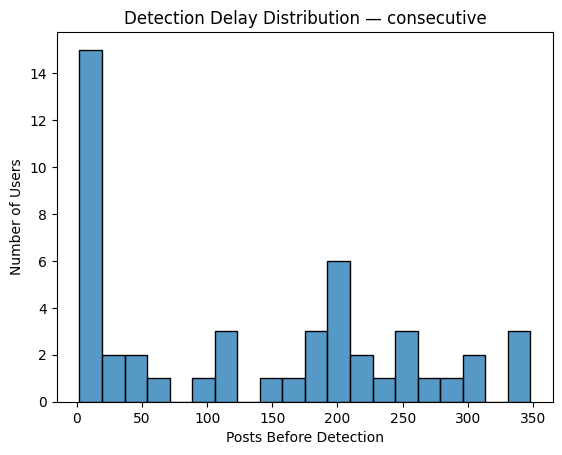

In [9]:
sns.histplot(summary["delay_post_count"].dropna(), bins=20)
plt.xlabel("Posts Before Detection")
plt.ylabel("Number of Users")
plt.title(f"Detection Delay Distribution — {m}")
plt.show()


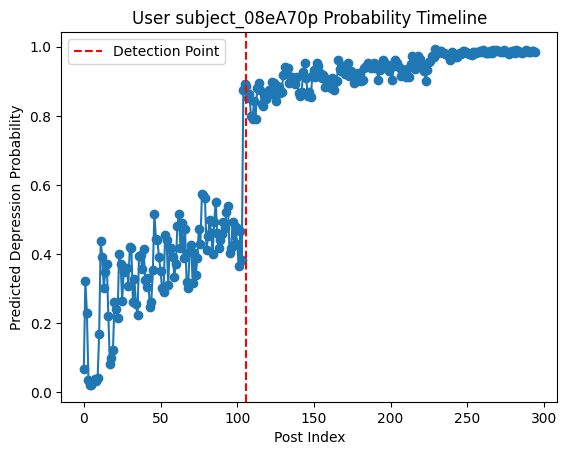

In [10]:
uid = summary.user_id.iloc[0]
u = results[results.user_id==uid]

plt.plot(u["prob"].values, marker='o')
if summary.loc[summary.user_id==uid,"delay_post_count"].values[0] is not None:
    d = summary.loc[summary.user_id==uid,"delay_post_count"].values[0]
    plt.axvline(d, color='red', linestyle='--', label="Detection Point")

plt.title(f"User {uid} Probability Timeline")
plt.ylabel("Predicted Depression Probability")
plt.xlabel("Post Index")
plt.legend()
plt.show()


In [57]:
# Helper functions and classes for user-level Transformer model
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Function to create sequences of user data for RNN input
def make_sequences(df, feature_cols):
    X_seqs = []
    y_labels = []
    
    # Group by user_id to create sequences
    for uid, g in df.groupby("user_id"):
        # Sort by created_utc to maintain temporal order
        g = g.sort_values("created_utc")
        # Extract feature columns and convert to tensor
        seq = torch.tensor(g[feature_cols].values, dtype=torch.float32)
        X_seqs.append(seq)
        # Depression or not
        y_labels.append(int(g["Depression"].max()))

    y_labels = torch.tensor(y_labels, dtype=torch.float32)

    return X_seqs, y_labels

# Collate function to pad sequences and create attention masks
def collate_fn(batch):
    seqs, labels = zip(*batch)

    padded = pad_sequence(seqs, batch_first=True)
    attention_mask = (padded.sum(dim=-1) != 0).long()
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded, attention_mask, labels

# Custom Dataset class for user sequences
class UserSeqDataset(Dataset):
    def __init__(self, X_seqs, y):
        self.X = X_seqs
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer-based model for user classification
class TransformerUserClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, n_heads=4, n_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            batch_first=True,
            dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Using mean pooling for classification
        self.cls_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, attention_mask, return_sequence=False):
        x = self.input_proj(x)
        src_key_padding_mask = (attention_mask == 0)
        out = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        token_logits = self.cls_head(out).squeeze(-1)   # shape [B, T]
    
        if return_sequence:
            return token_logits  

        out_masked = out.masked_fill(src_key_padding_mask.unsqueeze(-1), 0.0)
        valid_len = attention_mask.sum(dim=1).unsqueeze(-1)

        pooled = out_masked.sum(dim=1) / valid_len

        return self.cls_head(pooled).squeeze(1)
    
# Function to split data into training and validation sets at user level 
def user_split(df, val_ratio=0.15):
    users = df["user_id"].unique()
    labels = df.groupby("user_id")["Depression"].max()

    train_users, val_users = train_test_split(
        users,
        test_size=val_ratio,
        random_state=42,
        stratify=labels
    )

    df_train = df[df.user_id.isin(train_users)]
    df_val = df[df.user_id.isin(val_users)]

    return df_train, df_val

# Training function for the Transformer model
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4 ):
    device = next(model.parameters()).device
    pos_weight=torch.tensor([1], dtype=torch.float32).to(device)
    
    device = next(model.parameters()).device
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    best_val_loss = 1e10
    patience = 3
    patience_counter = 0

    for ep in range(1, epochs+1):
        model.train()
        total_train_loss = 0

        for x, mask, y in train_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x, mask)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, mask, y in val_loader:
                x, mask, y = x.to(device), mask.to(device), y.to(device)
                logits = model(x, mask)
                loss = criterion(logits, y)
                total_val_loss += loss.item()

        print(f"Epoch {ep}: Train Loss={total_train_loss/len(train_loader):.4f}, "
              f"Val Loss={total_val_loss/len(val_loader):.4f}")

        # Early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_state)

# Evaluation function for the Transformer model
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for x, mask, y in test_loader:
            x, mask = x.to(device), mask.to(device)
            logits = model(x, mask).cpu()
            all_logits.append(logits)
            all_labels.append(y)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    prob = torch.sigmoid(torch.tensor(logits)).numpy()
    pred = (prob >= 0.5).astype(int)

    print("==== Test Performance ====")
    print("Accuracy :", accuracy_score(labels, pred))
    print("Precision:", precision_score(labels, pred))
    print("Recall   :", recall_score(labels, pred))
    print("F1 Score :", f1_score(labels, pred))
    print("ROC-AUC  :", roc_auc_score(labels, prob))


In [58]:
# User level prediction with Transformer -phq9 Similarity Only
# prepare data loaders
phq9_test["created_utc"] = pd.to_datetime(phq9_test["created_utc"])
phq9_train["created_utc"] = pd.to_datetime(phq9_train["created_utc"])

phq9_train_user, phq9_val_user= user_split(phq9_train)

phq9_X_train, phq9_y_train = make_sequences(phq9_train_user, phq9_cols)
phq9_X_val, phq9_y_val = make_sequences(phq9_val_user, phq9_cols)
phq9_X_test, phq9_y_test = make_sequences(phq9_test, phq9_cols)

phq9_train_loader = DataLoader(UserSeqDataset(phq9_X_train, phq9_y_train), batch_size=16, shuffle=False, collate_fn=collate_fn)
phq9_val_loader   = DataLoader(UserSeqDataset(phq9_X_val, phq9_y_val), batch_size=16, shuffle=False, collate_fn=collate_fn)
phq9_test_loader  = DataLoader(UserSeqDataset(phq9_X_test, phq9_y_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# initialize and train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerUserClassifier(input_dim=len(phq9_cols)).to(device)
train_model(model, phq9_train_loader, phq9_val_loader, epochs=30)
#  Evaluate the model
evaluate_model(model, phq9_test_loader)


Epoch 1: Train Loss=0.3621, Val Loss=0.3436
Epoch 2: Train Loss=0.3312, Val Loss=0.3313
Epoch 3: Train Loss=0.2744, Val Loss=0.2020
Epoch 4: Train Loss=0.2060, Val Loss=0.1829
Epoch 5: Train Loss=0.2142, Val Loss=0.1953
Epoch 6: Train Loss=0.1993, Val Loss=0.1880
Epoch 7: Train Loss=0.1942, Val Loss=0.1827
Epoch 8: Train Loss=0.1948, Val Loss=0.1770
Epoch 9: Train Loss=0.1922, Val Loss=0.1910
Epoch 10: Train Loss=0.1864, Val Loss=0.1756
Epoch 11: Train Loss=0.1860, Val Loss=0.1749
Epoch 12: Train Loss=0.1846, Val Loss=0.1898
Epoch 13: Train Loss=0.1824, Val Loss=0.1745
Epoch 14: Train Loss=0.1858, Val Loss=0.1884
Epoch 15: Train Loss=0.1790, Val Loss=0.1762
Epoch 16: Train Loss=0.1850, Val Loss=0.1948
Early stopping!
==== Test Performance ====
Accuracy : 0.9550561797752809
Precision: 1.0
Recall   : 0.6190476190476191
F1 Score : 0.7647058823529411
ROC-AUC  : 0.8252957233848953


In [ ]:
# find early detection POINT
def infer_post_prob(model, df, feature_cols):
    model.eval()
    device = next(model.parameters()).device

    results = {}

    for uid, g in df.groupby("user_id"):
        g = g.sort_values("created_utc")
        seq = torch.tensor(g[feature_cols].values, dtype=torch.float32).unsqueeze(0).to(device)
        mask = torch.ones(seq.size()[:2]).long().to(device)

        with torch.no_grad():
            logits = model(seq, mask, return_sequence=True)[0].cpu().numpy()
            prob = torch.sigmoid(torch.tensor(logits)).numpy()

        results[uid] = dict(
            prob_seq = prob,
            posts = g["comment_id"].tolist(),
            label = int(g["Depression"].max())
        )

    return results
post_results = infer_post_prob(model, phq9_test, phq9_cols)
def eval_delay(post_results, th=0.5, k=5, method="consecutive"):
    out=[]

    for uid,r in post_results.items():
        p = r["prob_seq"]
        posts = r["posts"]
        y = r["label"]
        
        detect_idx=None

        if method=="max":       
            idx=np.argmax(p)
            if p[idx]>=th: detect_idx=idx

        elif method=="mean":     
            if np.mean(p)>=th:
                detect_idx=next((i for i,x in enumerate(p) if x>=th),None)

        elif method=="topk":     
            top=np.argsort(p)[-k:]
            if np.mean(p[top])>=th:
                detect_idx=min(top)

        elif method=="consecutive":  
            cnt=0
            for i,x in enumerate(p):
                cnt=cnt+1 if x>=th else 0
                if cnt>=k: detect_idx=i; break
        
        out.append([
            uid,y,
            1 if detect_idx is not None else 0,
            posts[detect_idx] if detect_idx is not None else None,
            detect_idx   # ← delay
        ])

    df=pd.DataFrame(out,columns=["user_id","label","pred","decision_post","delay"])
    return df

df_delay = eval_delay(post_results, th=0.42, k=7, method="consecutive")
print(df_delay.head())

true=df_delay["label"]
pred=df_delay["pred"]

print("Acc =",accuracy_score(true,pred))
print("Pre =",precision_score(true,pred))
print("Rec =",recall_score(true,pred))
print("F1  =",f1_score(true,pred))
print("\nmean delay =", df_delay['delay'].dropna().mean())
print("middle delay =", df_delay['delay'].dropna().median())


           user_id  label  pred decision_post  delay
0  subject_08eA70p      0     0          None    NaN
1  subject_0ROAtkI      0     0          None    NaN
2  subject_0bCCxpq      0     0          None    NaN
3  subject_0sOkMfd      0     0          None    NaN
4  subject_16b6b7C      0     0          None    NaN
Acc = 0.949438202247191
Pre = 0.9285714285714286
Rec = 0.6190476190476191
F1  = 0.7428571428571429

mean delay = 18.785714285714285
middle delay = 17.0
